# Dispersing Employee Workstation Locations with Simulated Annealing

Oragnizations preparing office ramp-up often reduce the number of on-site employees and re-allocate them in a way that workstations are dispersed as much as possible to minize the risk. This notebook illustrates dispersing optimzation process using simulated annealing. This method is useful when

- 1) furniture rearrange is not an option (possible locations are fixed)
- 2) number of employees are somehow fixed (X% of total seats or N empolyes per X sqft)
- 3) you have many floors 

We used Minimum nearest neighbor (min_nnd) as a cost function. PySal package was used for calculating this.

https://pysal.org/notebooks/explore/pointpats/distance_statistics.html

Then we optimized this cost with simulated annealing(SA) using perrygeo's package.

https://github.com/perrygeo/simanneal

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import libpysal as ps
from pointpats import PointPattern 
from simanneal import Annealer
import random

In [37]:
# gpkg not included in the repository.
gpkg = "../data/floorplan/plan_5256.gpkg"
# read layers
room = gpd.read_file(gpkg, driver='GPKG', layer='room')
floor = gpd.read_file(gpkg, driver='GPKG', layer='floor')
graphic = gpd.read_file(gpkg, driver='GPKG', layer='graphic')

label = room.copy().drop(columns='geometry')
label['geometry'] = room['geometry'].representative_point()

In [38]:
# create current occupancy column from the column with concatenated occupant list 
label['current_cap'] = label['OCCLIST'].map(lambda x: len(x.split(";")) if x else 0)

# Select Offices
-  mark current office space
- label current number of occupants for each office space

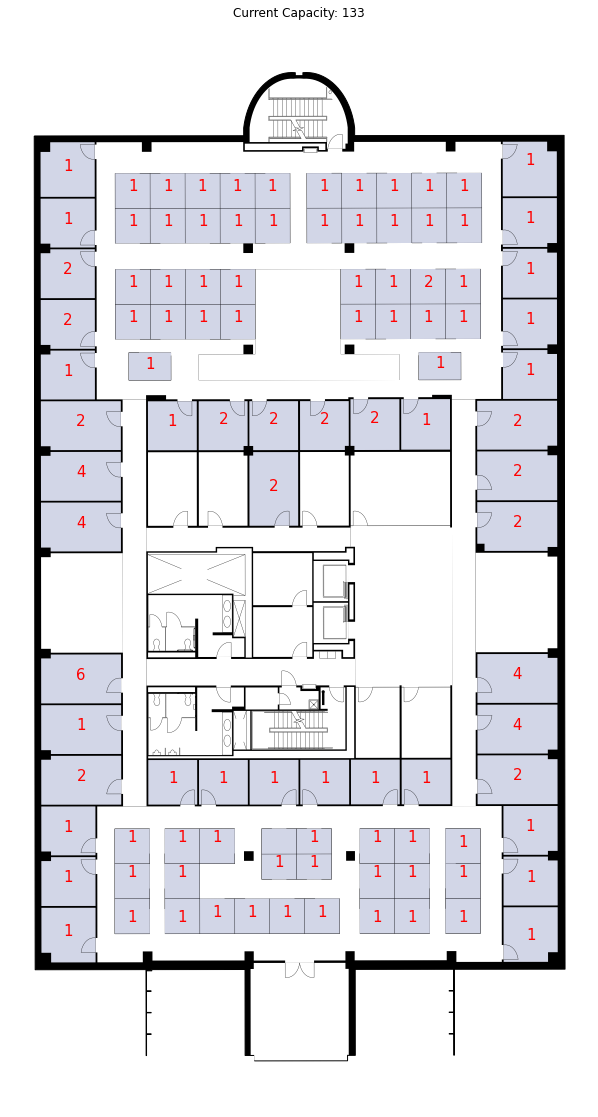

In [39]:
rmtyps = ["Office"]
rooms_occ = room[room["RMTYPDESCR"].isin(rmtyps)]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
ax.axis("off")
floor.plot(ax=ax, facecolor='black', edgecolor='black')
room.plot(ax=ax, facecolor='white', edgecolor=None)
rooms_occ.plot(ax=ax, facecolor='#22338833', edgecolor=None)
graphic.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=0.3)
ax.set_title(f"Current Capacity: {label['current_cap'].sum()}")
for x, y, text in zip(label.geometry.x, label.geometry.y, label["current_cap"]):
    if  text != 0:
        ax.text(x, y, text, fontsize = 15, horizontalalignment='center', color='red')

# Re-allocation Strategy
- assign one person to each 'room' office
- vacate ~70% cubicles and disperse 30% as much as possible.

In [40]:
cubicle_subtypes = ['15', '16', '17', '18', '27']
condition_office_room = ~label['RMSUBTYP'].isin(cubicle_subtypes) & (label['RMTYP']=='310')
condition_office_cubicle = label['RMSUBTYP'].isin(cubicle_subtypes) & (label['RMTYP']=='310')
office_room = label[condition_office_room]
office_cubicle = label[condition_office_cubicle]

## 'Room' Offices

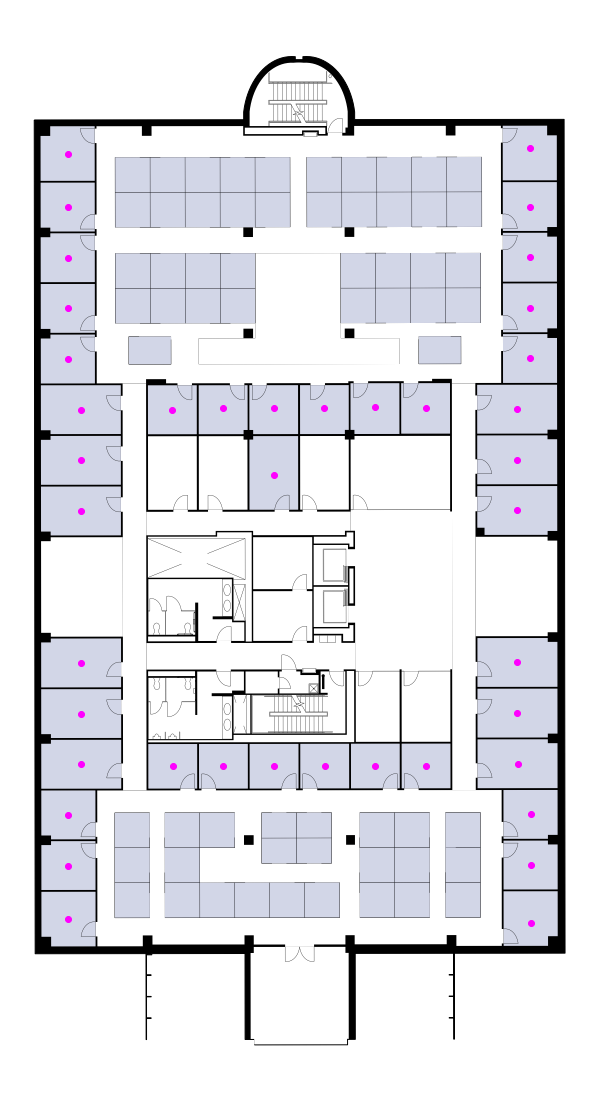

In [41]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
ax.axis("off")
floor.plot(ax=ax, facecolor='black', edgecolor='black')
room.plot(ax=ax, facecolor='white', edgecolor=None)
rooms_occ.plot(ax=ax, facecolor='#22338833', edgecolor=None)
graphic.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=0.3)
office_room.plot(ax=ax, facecolor='magenta')

In [42]:
print(f"{len(office_room)} people allocated to each room office")

41 people allocated to each room office


## Cubicles

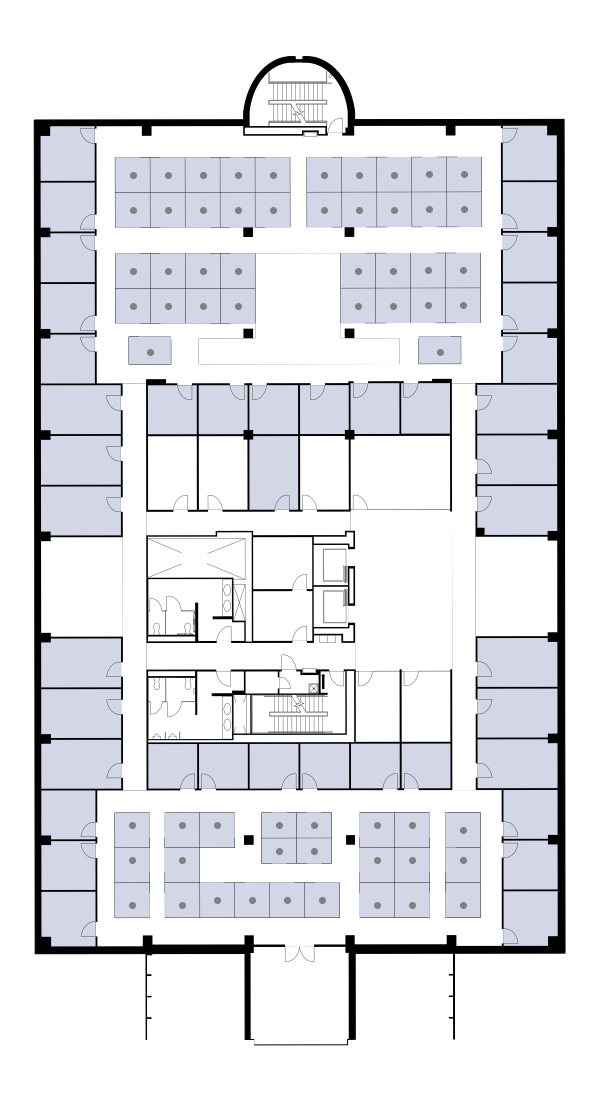

In [43]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
ax.axis("off")
floor.plot(ax=ax, facecolor='black', edgecolor='black')
room.plot(ax=ax, facecolor='white', edgecolor=None)
rooms_occ.plot(ax=ax, facecolor='#22338833', edgecolor=None)
graphic.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=0.3)
office_cubicle.plot(ax=ax, facecolor='gray')

In [44]:
print(f"Total number of cubicles: {len(office_cubicle)}")

Total number of cubicles: 62


## Disperse work locations with Simulated Annealing
We need to pick up 30% locations that are dispersed as much as possible.

In [55]:
class DispersedSeats(Annealer):

    def __init__(self, gpd, sample_rate=0.3):
        self.gpd = gpd
        sample_size = round(len(gpd) * sample_rate)
        init_state = list(np.random.choice(self.gpd.index, sample_size, replace=False).copy())
        super(DispersedSeats, self).__init__(init_state) 

    def move(self):
        remain = [id for id in self.gpd.index if id not in self.state]
        pick_state = self.random_pick(self.state)
        pick_remain = self.random_pick(remain)
        self.state.append(pick_remain)
        remain.append(pick_state)
    
    def nnd(self, points):
        return PointPattern(points).min_nnd
    
    def gpd2nparray(self, gpd, geom='geometry'):
        return np.asarray([(pnt.x, pnt.y) for pnt in gpd[geom]])
    
    def energy(self):
        sample = self.gpd[self.gpd.index.isin(self.state)]
        mean_nnd = self.nnd(self.gpd2nparray(sample))
        return -mean_nnd

    def random_pick(self, candidates):
        random.shuffle(candidates)
        return candidates.pop()

In [56]:
ds = DispersedSeats(office_cubicle, sample_rate=0.3)
print(ds.energy())
Tmax = 200000.0
Tmin = 1.5
ds.steps = 100000
ds.set_schedule(ds.auto(minutes=1))
ds.copy_strategy = "slice"
state, e = ds.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


-2.16273274828203


     0.00087         -6.67     0.45%     0.00%     0:02:27     0:03:41 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00087         -5.97     2.50%     0.00%     0:00:59     0:00:00

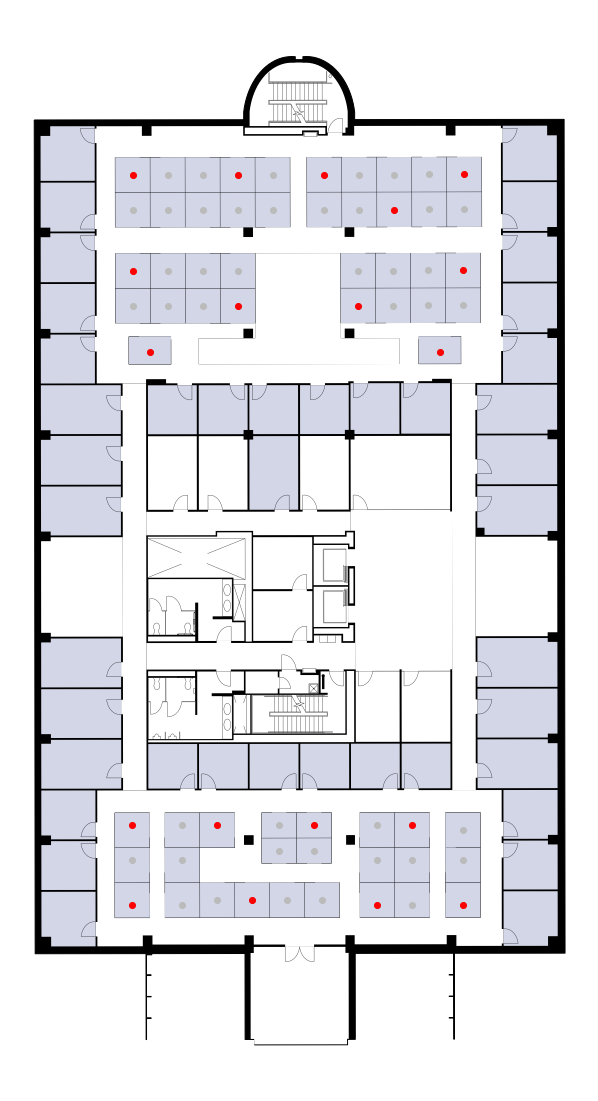

In [57]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
ax.axis("off")
floor.plot(ax=ax, facecolor='black', edgecolor='black')
room.plot(ax=ax, facecolor='white', edgecolor=None)
rooms_occ.plot(ax=ax, facecolor='#22338833', edgecolor=None)
graphic.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=0.3)
office_cubicle.plot(ax=ax, facecolor='#BBBBBB')
office_cubicle[office_cubicle.index.isin(state)].plot(ax=ax, facecolor='red')

# Plot all in one.

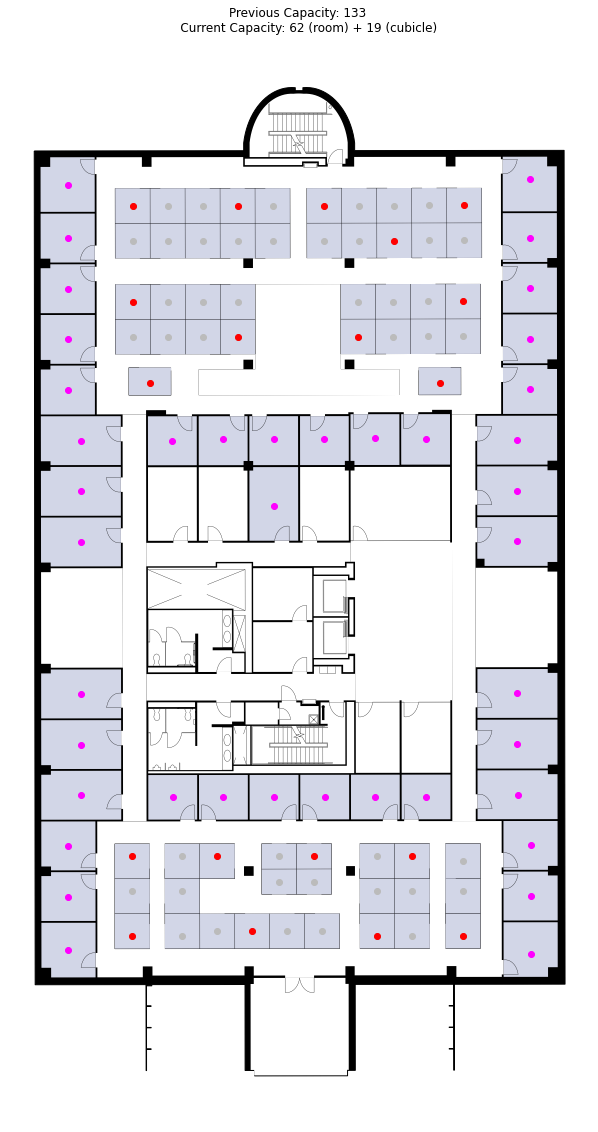

In [59]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20, 20)
ax.axis("off")
ax.set_title(f"Previous Capacity: {label['current_cap'].sum()} \n \
    Current Capacity: {len(office_cubicle)} (room) + {len(office_cubicle[office_cubicle.index.isin(state)])} (cubicle)")
floor.plot(ax=ax, facecolor='black', edgecolor='black')
room.plot(ax=ax, facecolor='white', edgecolor=None)
rooms_occ.plot(ax=ax, facecolor='#22338833', edgecolor=None)
graphic.plot(ax=ax, facecolor='None', edgecolor='black', linewidth=0.3)
office_room.plot(ax=ax, facecolor='magenta')
office_cubicle.plot(ax=ax, facecolor='#BBBBBB')
office_cubicle[office_cubicle.index.isin(state)].plot(ax=ax, facecolor='red')